In [145]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn import metrics


In [146]:
data_label = pd.read_csv('trainingset_label.csv')
data_label.head()


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [147]:
data = pd.read_csv('trainingSetValues.csv')
data.head()

testData = pd.read_csv('testSetValues.csv')


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [149]:
# making new data frame with dropped NA values
new_data = data.dropna(axis = 0, how ='any')
   


In [150]:
print("Old data frame length:", len(data))
print("New data frame length:", len(new_data))
print("Number of rows with at least 1 NA value: ", (len(data)-len(new_data)))

Old data frame length: 59400
New data frame length: 27813
Number of rows with at least 1 NA value:  31587


In [151]:
#merging training data and lab
merge_data = data.merge(data_label, how = "outer", on = "id", sort = True)  #merging training data and label 
merge_data = merge_data.fillna(merge_data.median())

merge_data.to_csv("train_data.csv", index = False)
trainData = pd.read_csv("train_data.csv")
trainData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,1,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,2,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,3,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,4,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [152]:
trainData.shape

#check how many null values each column has
trainData.apply(lambda x: sum(x.isnull()))

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [153]:
#Checking for redundant row
trainData.duplicated().sum()

0

In [154]:
trainData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,1,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,2,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,3,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,4,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [155]:
#converting date column to date format for train data
trainData['date_recorded'] = pd.to_datetime(trainData['date_recorded']).dt.date  

#converting date column to date format for test data
testData['date_recorded'] = pd.to_datetime(testData['date_recorded']).dt.date 

In [156]:
#Taking the target classify group into y
#y = trainData.status_group


# dropping unnecessary columns from train data
trainData.drop(columns={"id","amount_tsh","funder","installer","subvillage",
                   "region_code","district_code","recorded_by","scheme_name","payment", "num_private"},inplace=True)


trainData

,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,population,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,2012-11-13,0,33.125828,-5.118154,Mratibu,Lake Tanganyika,Tabora,Uyui,Igalula,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,2011-03-05,1978,34.770717,-9.395642,none,Rufiji,Iringa,Njombe,Uwemba,20,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,2011-03-27,0,36.115056,-6.279268,Bombani,Wami / Ruvu,Dodoma,Chamwino,Msamalo,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,2013-06-03,1639,37.147432,-3.187555,Area 7 Namba 5,Pangani,Kilimanjaro,Hai,Masama Magharibi,25,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,2011-03-22,0,36.164893,-6.099289,Ezeleda,Wami / Ruvu,Dodoma,Chamwino,Majeleko,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,2013-03-22,1183,37.007726,-3.280868,Upendo Primary School,Pangani,Arusha,Meru,King'ori,350,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
59396,2011-04-12,0,33.724987,-8.940758,Kwa Mvulula,Rufiji,Mbeya,Mbeya Rural,Ilungu,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,2012-11-13,1188,33.963539,-1.429477,Kwa Wambura Msege,Lake Victoria,Mara,Rorya,Komuge,95,...,soft,good,enough,enough,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
59398,2011-03-07,1428,35.630481,-7.710549,none,Rufiji,Iringa,Iringa Rural,Kiwere,1,...,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


In [157]:
# dropping unnecessary columns from test data
testData.drop(columns={"amount_tsh","funder","installer","subvillage",
                   "region_code","district_code","recorded_by","scheme_name","payment", "num_private"},inplace=True)


testData

,id,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,2013-02-04,1996,35.290799,-4.059696,Dinamu Secondary School,Internal,Manyara,Mbulu,Bashay,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,2013-02-04,1569,36.656709,-3.309214,Kimnyak,Pangani,Arusha,Arusha Rural,Kimnyaki,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,2013-02-01,1567,34.767863,-5.004344,Puma Secondary,Internal,Singida,Singida Rural,Puma,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,2013-01-22,267,38.058046,-9.418672,Kwa Mzee Pange,Ruvuma / Southern Coast,Lindi,Liwale,Mkutano,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,2013-03-27,1260,35.006123,-10.950412,Kwa Mzee Turuka,Ruvuma / Southern Coast,Ruvuma,Mbinga,Mbinga Urban,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,2011-02-24,34,38.852669,-6.582841,Kwambwezi,Wami / Ruvu,Pwani,Bagamoyo,Yombo,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,2011-03-21,0,37.451633,-5.350428,Bonde La Mkondoa,Pangani,Tanga,Kilindi,Mvungwe,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,2013-03-04,1476,34.739804,-4.585587,Bwawani,Internal,Singida,Singida Rural,Ughandi,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,2013-02-18,998,35.432732,-10.584159,Kwa John,Lake Nyasa,Ruvuma,Songea Rural,Maposeni,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [158]:
#Replace null values for training data

trainData.replace(np.nan,'0',inplace = True)

#Check the changes now
trainData.isnull().sum()

date_recorded            0
gps_height               0
longitude                0
latitude                 0
wpt_name                 0
basin                    0
region                   0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

In [159]:

X= trainData

X.shape

#dropped NA values for train data
X = X.dropna(axis = 0, how ='any')
X



,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,population,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,2012-11-13,0,33.125828,-5.118154,Mratibu,Lake Tanganyika,Tabora,Uyui,Igalula,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,2011-03-05,1978,34.770717,-9.395642,none,Rufiji,Iringa,Njombe,Uwemba,20,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,2011-03-27,0,36.115056,-6.279268,Bombani,Wami / Ruvu,Dodoma,Chamwino,Msamalo,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,2013-06-03,1639,37.147432,-3.187555,Area 7 Namba 5,Pangani,Kilimanjaro,Hai,Masama Magharibi,25,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,2011-03-22,0,36.164893,-6.099289,Ezeleda,Wami / Ruvu,Dodoma,Chamwino,Majeleko,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,2013-03-22,1183,37.007726,-3.280868,Upendo Primary School,Pangani,Arusha,Meru,King'ori,350,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
59396,2011-04-12,0,33.724987,-8.940758,Kwa Mvulula,Rufiji,Mbeya,Mbeya Rural,Ilungu,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,2012-11-13,1188,33.963539,-1.429477,Kwa Wambura Msege,Lake Victoria,Mara,Rorya,Komuge,95,...,soft,good,enough,enough,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
59398,2011-03-07,1428,35.630481,-7.710549,none,Rufiji,Iringa,Iringa Rural,Kiwere,1,...,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


In [160]:
T= testData 
#dropped NA values for test data
T = T.dropna(axis = 0, how ='any')
testindex = T.id
T.shape

T = T.drop(["id"], axis=1)
T

,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,population,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2013-02-04,1996,35.290799,-4.059696,Dinamu Secondary School,Internal,Manyara,Mbulu,Bashay,321,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,2013-02-04,1569,36.656709,-3.309214,Kimnyak,Pangani,Arusha,Arusha Rural,Kimnyaki,300,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
5,2013-03-04,1685,36.685279,-3.302420,Masaga,Pangani,Arusha,Arusha Rural,Ilkiding'a,200,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
6,2011-03-02,550,36.398041,-7.541382,none,Rufiji,Iringa,Kilolo,Mahenge,600,...,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,2013-01-25,234,39.607420,-10.893786,Kwa Mkwaa,Ruvuma / Southern Coast,Mtwara,Tandahimba,Maundo,1,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14844,2012-11-07,0,34.096878,-3.079689,Ikanayugu,Lake Victoria,Shinyanga,Maswa,Ipililo,0,...,other,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14845,2011-02-24,34,38.852669,-6.582841,Kwambwezi,Wami / Ruvu,Pwani,Bagamoyo,Yombo,20,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,2011-03-21,0,37.451633,-5.350428,Bonde La Mkondoa,Pangani,Tanga,Kilindi,Mvungwe,2960,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14848,2013-02-18,998,35.432732,-10.584159,Kwa John,Lake Nyasa,Ruvuma,Songea Rural,Maposeni,150,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [161]:
#Outlier detection
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(X < (Q1 - 1.5 * IQR)) or (X > (Q3 + 1.5 * IQR))

gps_height           1319.250000
longitude               4.088039
latitude                5.214466
population            215.000000
construction_year    2004.000000
dtype: float64
       basin  construction_year  date_recorded  extraction_type  \
0      False              False          False            False   
1      False              False          False            False   
2      False              False          False            False   
3      False              False          False            False   
4      False              False          False            False   
...      ...                ...            ...              ...   
59395  False              False          False            False   
59396  False              False          False            False   
59397  False              False          False            False   
59398  False              False          False            False   
59399  False              False          False            False   

       extracti

,basin,construction_year,date_recorded,extraction_type,extraction_type_class,extraction_type_group,gps_height,latitude,lga,longitude,...,scheme_management,source,source_class,source_type,status_group,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59396,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59397,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59398,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [162]:
#transforming training data
from sklearn.preprocessing import LabelEncoder
LbEn = LabelEncoder()

X["date_recorded"] = LbEn.fit_transform(X["date_recorded"])
X["longitude"] = LbEn.fit_transform(X["longitude"])
X["latitude"] = LbEn.fit_transform(X["latitude"])
X["wpt_name"] = LbEn.fit_transform(X["wpt_name"])
X["basin"] = LbEn.fit_transform(X["basin"])
X["region"] = LbEn.fit_transform(X["region"])
X["lga"] = LbEn.fit_transform(X["lga"])
X["ward"] = LbEn.fit_transform(X["ward"])
X["population"] = LbEn.fit_transform(X["population"])
X["public_meeting"] = LbEn.fit_transform(X["public_meeting"])
X["scheme_management"] = LbEn.fit_transform(X["scheme_management"])
X["permit"] = LbEn.fit_transform(X["permit"])
X["construction_year"] = LbEn.fit_transform(X["construction_year"])
X["extraction_type"] = LbEn.fit_transform(X["extraction_type"])
X["extraction_type_group"] = LbEn.fit_transform(X["extraction_type_group"])
X["extraction_type_class"] = LbEn.fit_transform(X["extraction_type_class"])
X["management"] = LbEn.fit_transform(X["management"])
X["management_group"] = LbEn.fit_transform(X["management_group"])
X["payment_type"] = LbEn.fit_transform(X["payment_type"])
X["water_quality"] = LbEn.fit_transform(X["water_quality"])
X["quality_group"] = LbEn.fit_transform(X["quality_group"])
X["quantity"] = LbEn.fit_transform(X["quantity"])
X["quantity_group"] = LbEn.fit_transform(X["quantity_group"])
X["source"] = LbEn.fit_transform(X["source"])
X["source_type"] = LbEn.fit_transform(X["source_type"])
X["source_class"] = LbEn.fit_transform(X["source_class"])
X["waterpoint_type_group"] = LbEn.fit_transform(X["waterpoint_type_group"])
X["waterpoint_type"] = LbEn.fit_transform(X["waterpoint_type"])

X["status_group"] = LbEn.fit_transform(X["status_group"])


X.select_dtypes("object").columns



Index([], dtype='object')

In [163]:
#transforming test data

from sklearn.preprocessing import LabelEncoder
LbEn = LabelEncoder()



T["date_recorded"] = LbEn.fit_transform(T["date_recorded"])
T["longitude"] = LbEn.fit_transform(T["longitude"])
T["latitude"] = LbEn.fit_transform(T["latitude"])
T["wpt_name"] = LbEn.fit_transform(T["wpt_name"])
T["basin"] = LbEn.fit_transform(T["basin"])
T["region"] = LbEn.fit_transform(T["region"])
T["lga"] = LbEn.fit_transform(T["lga"])
T["ward"] = LbEn.fit_transform(T["ward"])
T["population"] = LbEn.fit_transform(T["population"])
T["public_meeting"] = LbEn.fit_transform(T["public_meeting"])
T["scheme_management"] = LbEn.fit_transform(T["scheme_management"])
T["permit"] = LbEn.fit_transform(T["permit"])
T["construction_year"] = LbEn.fit_transform(T["construction_year"])
T["extraction_type"] = LbEn.fit_transform(T["extraction_type"])
T["extraction_type_group"] = LbEn.fit_transform(T["extraction_type_group"])
T["extraction_type_class"] = LbEn.fit_transform(T["extraction_type_class"])
T["management"] = LbEn.fit_transform(T["management"])
T["management_group"] = LbEn.fit_transform(T["management_group"])
T["payment_type"] = LbEn.fit_transform(T["payment_type"])
T["water_quality"] = LbEn.fit_transform(T["water_quality"])
T["quality_group"] = LbEn.fit_transform(T["quality_group"])
T["quantity"] = LbEn.fit_transform(T["quantity"])
T["quantity_group"] = LbEn.fit_transform(T["quantity_group"])
T["source"] = LbEn.fit_transform(T["source"])
T["source_type"] = LbEn.fit_transform(T["source_type"])
T["source_class"] = LbEn.fit_transform(T["source_class"])
T["waterpoint_type_group"] = LbEn.fit_transform(T["waterpoint_type_group"])
T["waterpoint_type"] = LbEn.fit_transform(T["waterpoint_type"])




T.select_dtypes("object").columns

Index([], dtype='object')

In [164]:
#Dropping target group from train data
y = X["status_group"]
X = X.drop(["status_group"], axis=1)


X

,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,population,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,229,0,13264,28993,29562,3,19,124,315,0,...,6,3,3,1,1,7,5,0,4,3
1,38,1978,26428,7686,37399,6,3,91,2048,20,...,2,6,2,1,1,7,5,0,4,3
2,60,0,35409,24830,1066,8,2,11,1356,0,...,5,6,2,2,2,3,0,0,2,1
3,340,1639,42511,47836,445,5,6,16,1090,25,...,5,6,2,1,1,8,6,0,1,1
4,55,0,35674,25765,2597,8,2,11,1002,0,...,6,6,2,0,0,7,5,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,325,1183,41424,45762,36676,5,0,65,700,343,...,6,6,2,2,2,5,3,1,1,1
59396,76,0,17794,12232,17195,6,10,60,382,0,...,3,6,2,1,1,6,4,1,1,1
59397,229,1188,20028,56266,23882,4,9,97,800,95,...,2,6,2,1,1,2,4,1,2,1
59398,40,1428,32251,18266,37399,6,3,24,790,1,...,5,6,2,0,0,8,6,0,1,1


In [165]:
#import seaborn as sns
#Correlation 

#X.corr()

#Correlation plot

#sns.heatmap(X.corr())
#pd.DataFrame(X).T.plot()
#plt.show()

In [166]:
print(y)

0        2
1        0
2        0
3        0
4        2
        ..
59395    0
59396    0
59397    2
59398    2
59399    2
Name: status_group, Length: 59400, dtype: int32


In [167]:
# report which features were selected by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
rfe.fit(X, y)

print("The optimal number of features:", rfe.n_features_)
print("Best features:", X.columns[rfe.support_])

# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    

The optimal number of features: 26
Best features: Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'wpt_name',
       'basin', 'region', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'waterpoint_type'],
      dtype='object')
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1

In [168]:
#Taking the selected features to use for our model

selected_features = rfe.get_support(1)
X = X[X.columns[selected_features]]
T = T[T.columns[selected_features]]


In [169]:
T

,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,lga,ward,population,...,extraction_type_class,management,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type
0,243,1996,6065,8098,567,0,8,61,16,256,...,3,3,2,6,2,3,3,5,3,6
1,243,1569,7706,9601,1494,5,0,0,583,246,...,0,7,2,6,2,2,2,8,6,1
5,271,1685,7763,9648,6732,5,0,0,302,166,...,0,7,2,6,2,1,1,8,6,1
6,33,550,7480,3815,9217,6,3,33,830,392,...,1,7,2,4,4,1,1,3,0,4
7,233,234,11988,260,4156,7,12,111,941,1,...,5,7,2,6,2,0,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14844,194,0,4438,10571,926,4,17,56,323,0,...,1,11,4,6,2,1,1,7,5,4
14845,27,34,11088,4829,6220,8,14,2,1741,18,...,2,7,2,6,2,1,1,6,4,1
14846,52,0,9238,6045,303,5,20,32,1209,558,...,1,7,0,4,4,2,2,7,5,4
14848,257,998,6286,635,3021,1,16,106,893,128,...,0,7,2,6,2,2,2,6,4,1


In [170]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

In [171]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model = LogisticRegressionCV(cv=5, max_iter = 2500, n_jobs=-1)
model.fit(X_train, y_train)

#predicted_train = LRmodel.predict(X_train)
#predicted_test = LRmodel.predict(X_test)

y_pred_train = model.predict(X_validation)

y_pred_test = model.predict(T)

print("LogisticRegression accuracy: " + str(accuracy_score(y_validation, y_pred_train)*100))

confusion = confusion_matrix(y_validation, y_pred_train)
print('\nConfusion Matrix\n')
print(confusion)

# print precision and recall statistics

print('\nMicro Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred_train, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred_train, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, y_pred_train, average='weighted')))

LogisticRegression accuracy: 61.2037037037037

Confusion Matrix

[[5245    0 1190]
 [ 727    0  158]
 [2534    0 2026]]

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.41
Macro Recall: 0.42
Macro F1-score: 0.40

Weighted Precision: 0.56
Weighted Recall: 0.61
Weighted F1-score: 0.58


In [172]:
#Tuning hyperparameter for Randomforest using GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(criterion='gini',
                                max_features='auto',
                                min_samples_split=6,
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = {"n_estimators" : [600, 900, 1200]}

gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())

print(gs.best_score_)
print(gs.best_params_)
es=gs.best_params_

0.7984006734006734
{'n_estimators': 900}


In [173]:
#X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

In [174]:
#model Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(
    n_estimators=1200, 
    max_features='auto', 
    min_samples_split=6,
    n_jobs=-1, 
    random_state=42)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_validation)

y_pred_test = model.predict(T)
print("RandomForest accuracy: " + str(accuracy_score(y_validation, y_pred_train)*100))
#print("RandomForest test accuracy: " + str(accuracy_score(y_validation, y_pred_test)*100))

RandomForest accuracy: 81.12794612794613


In [175]:
#Showing confusion Matrix and precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

confusion = confusion_matrix(y_validation, y_pred_train)
print('Confusion Matrix\n')
print(confusion)


#importing accuracy_score, precision_score, recall_score, f1_score



print('Micro Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred_train, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred_train, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, y_pred_train, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, y_pred_train, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, y_pred_train, average='weighted')))


Confusion Matrix

[[5805  110  520]
 [ 447  312  126]
 [ 997   42 3521]]
Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.77
Macro Recall: 0.68
Macro F1-score: 0.71

Weighted Precision: 0.81
Weighted Recall: 0.81
Weighted F1-score: 0.80


In [176]:
#Prediction array on test data
    
y_pred_test

array([2, 0, 0, ..., 0, 0, 2])

In [177]:

data = {'ID': testindex, 'status_group': y_pred_test}


predData = pd.DataFrame(data=data)

valueReplace = {0:'functional', 1:'functional needs repair',
                           2:'non functional'}

predData.status_group = predData.status_group.replace(valueReplace)        

predData.to_csv('SubmissionFormat.csv', index=False)
        

In [178]:

print('Test Data')
print(predData.status_group.value_counts())

data = {'status_group': y_pred_train}


predData_train = pd.DataFrame(data=data)

valueReplace = {0:'functional', 1:'functional needs repair',
                           2:'non functional'}

predData_train.status_group = predData_train.status_group.replace(valueReplace) 

print('Training data')
print(predData_train.status_group.value_counts())

Test Data
functional                 8730
non functional             3682
functional needs repair      86
Name: status_group, dtype: int64
Training data
functional                 7249
non functional             4167
functional needs repair     464
Name: status_group, dtype: int64


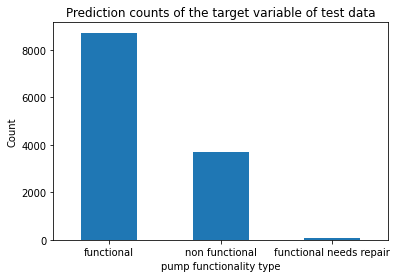

In [179]:
predData.status_group.value_counts().plot(kind="bar")
plt.title("Prediction counts of the target variable of test data")
plt.xlabel("pump functionality type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

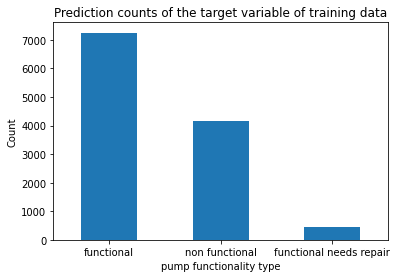

In [180]:
predData_train.status_group.value_counts().plot(kind="bar")
plt.title("Prediction counts of the target variable of training data")
plt.xlabel("pump functionality type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()